#### Question-2: This data set describes operating conditions of a reactor and contains class labels about whether the reactor will operate or fail under those operating conditions. Your job is to construct a logistic regression model to predict the same.
- Describe the statistics of the data.
- Partition your data into a training set and a test set. Keep 70% of your data for training and set aside the remaining 30% for testing.
- Fit a logistic regression model on the training set. Choose an appropriate objective function to quantify classification error. Manually code for the gradient descent procedure used to find optimum model parameters. (Note: You may need to perform multiple initializations to avoid local minima)
- Evaluate the performance of above model on your test data. Report the confusion matrix and the F1 Score.

In [1]:
# Resetting variables
%reset -f

In [2]:
import numpy as np
import pandas as pd
import math 
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib notebook
import os
import random

In [3]:
# Setting up required directories
parentDirectory = 'G:\Academic\Coursework\CH5019 - Mathematical Foundations of Data Science\Term project 2020\Dataset_Question2/'
imageDirectory = 'G:\Academic\Coursework\CH5019 - Mathematical Foundations of Data Science\Term project 2020\Dataset_Question2\Images/'

In [4]:
# Reading the dataset
os.chdir(parentDirectory)
reactorData=pd.read_csv('Dataset_Question2.csv')
reactorData.head()

,Temperature,Pressure,Feed Flow rate,Coolant Flow rate,Inlet reactant concentration,Test
0,406.86,17.66,121.83,2109.20,0.1033,Pass
1,693.39,24.66,133.18,3138.96,0.3785,Pass
2,523.10,23.23,146.55,1058.24,0.4799,Fail
3,612.86,40.97,94.44,1325.12,0.3147,Fail
4,500.28,37.44,185.48,2474.51,0.2284,Pass


In [5]:
# Statistical description of the data
reactorData.describe()

,Temperature,Pressure,Feed Flow rate,Coolant Flow rate,Inlet reactant concentration
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,546.76643,25.493270,125.029060,2295.797770,0.302692
std,86.85878,14.252407,43.508159,763.680625,0.116062
min,400.31000,1.060000,50.030000,1002.530000,0.100300
25%,469.73500,12.725000,88.587500,1635.682500,0.199075
50%,545.80000,25.375000,124.590000,2268.710000,0.308850
75%,618.87750,37.820000,162.562500,2983.692500,0.401625
max,699.87000,49.890000,199.960000,3595.620000,0.499600


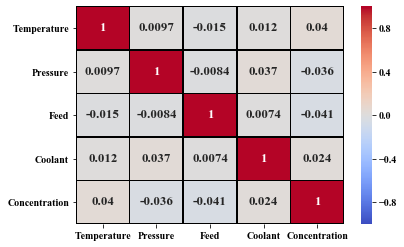

In [6]:
# Correlation matrix heatmap for all feature variables
plt.rcParams['font.family'] = "Times New Roman"
dataCopy = reactorData.copy(deep=True)
dataCopy = dataCopy.rename(columns={'Feed Flow rate': 'Feed', 'Coolant Flow rate': 'Coolant','Inlet reactant concentration':'Concentration'})
gif = sns.heatmap(dataCopy.corr(),annot=True,vmin=-1,vmax=1,center=0,cmap='coolwarm',annot_kws={"size":13},linewidths=0.5, linecolor='black')
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

#os.chdir(imageDirectory)
#plt.gcf().subplots_adjust(left=0.16); plt.gcf().subplots_adjust(bottom=0.1)
#plt.savefig('correlation_heatmap.jpg',dpi=150)
#os.chdir(parentDirectory)
plt.show()

In [7]:
# Count of total 'Pass' and 'Fail'
passCount = reactorData['Test'].loc[reactorData['Test']=='Pass'].count()
failCount = len(reactorData)-passCount
print("Pass = "+str(passCount)+" ; Fail = "+str(failCount))

Pass = 585 ; Fail = 415


##### Splitting data: 70% for training and 30% for testing

In [8]:
trainingData = pd.DataFrame(columns=reactorData.columns)
testingData = pd.DataFrame(columns=reactorData.columns)
dataIndex = [x for x in range(len(reactorData))]
for i in range(len(reactorData)):
    index = random.choice(dataIndex)
    if i<(0.7*len(reactorData)):
        row = reactorData.loc[index,:]
        trainingData = trainingData.append(row,ignore_index=True)
    else:
        row = reactorData.loc[index,:]
        testingData = testingData.append(row,ignore_index=True)
    dataIndex.remove(index)

X_train = trainingData.iloc[:,:5].values  # training input
y_train = trainingData.iloc[:,5].values  # training output
X_test = testingData.iloc[:,:5].values  # testing input
y_test = testingData.iloc[:,5].values  # testing output
y_train = np.where(y_train=='Pass',1,0)  # Setting binary output labels: 1 = 'Pass' and 0 = 'Fail'
y_test = np.where(y_test=='Pass',1,0)

##### Standardizing the features
$\frac{X-\bar{X}}{\sqrt{\text{mean}\left(\left(|X-\bar{X}|\right)^2\right)}}$

In [9]:
for i in range(X_train.shape[1]):
    X_train[:,i] = (X_train[:,i]-X_train[:,i].mean())/X_train[:,i].std()
    X_test[:,i] = (X_test[:,i]-X_test[:,i].mean())/X_test[:,i].std()

##### Building a Logistic Regression model

In [10]:
class logisticRegression:

    def __init__(self, learningRate=0.001, numIters=1000):  # Using __init__ method for initializing the objects
        self.alpha = learningRate
        self.numIters = numIters
        self.weights = None
        self.bias = None
        
    def sigmoidFunction(self,z):  # Defining the sigmoid function
        return 1/(1+np.exp(-z))
    
    def costFunction(self,y,yPredicted):
        J = -y.dot(np.log(yPredicted))-((1-y).dot(np.log(1-yPredicted)))  # Compute cost for the given parameters
        return J

    def fit(self,X,y,weights,bias):  # Defining function to fit the model to the training dataset
                                     # Contains the training step and the gradient descent

        # Initializing the parameters (weights and bias)
        self.weights = weights
        self.bias = bias

        # Gradient descent
        cost = []
        for _ in range(self.numIters):
            linearModel = np.dot(X,self.weights)+self.bias  # Approximating y with linear combination of weights and x, plus bias
            yPredicted = self.sigmoidFunction(linearModel)  # Applying the sigmoid function to get the predicted probability value

            # Computing gradients
            dw = (1.0/numOfRecords)*np.dot(X.T,(yPredicted-y))
            db = (1.0/numOfRecords)*np.sum(yPredicted-y)
            
            # Update the parameters (weights and bias)
            self.weights -= self.alpha*dw
            self.bias -= self.alpha*db
            cost.append(self.costFunction(y,yPredicted))
        return cost

    def predictor(self,X):  # Defining function to predict the output for an unknown dataset
        linearModel = np.dot(X,self.weights)+self.bias
        yPredicted = self.sigmoidFunction(linearModel)
        predictedClass = [1 if i>0.5 else 0 for i in yPredicted]
        return np.array(predictedClass)

In [11]:
def accuracy(y_true,y_pred):  # Defining function to calculate the accuracy of prediction
    accuracy = np.sum(y_true==y_pred)/len(y_true)
    return accuracy

##### Performing logistic regression and predicting

Logistic regression classifier accuracy = 95.33%

Plot: Cost v/s Iterations


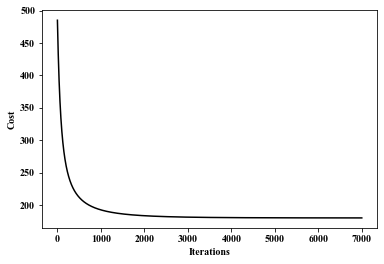

In [12]:
alpha = 0.03  # Learning rate
numOfIterations = 7000  # Number of iterations
numOfRecords,numOfFeatures = X_train.shape
weights = np.zeros(numOfFeatures);   bias = 0  # Initializing weights and bias to zero
regressor = logisticRegression(learningRate=alpha,numIters=numOfIterations)
cost = regressor.fit(X_train,y_train,weights,bias)
predictions = regressor.predictor(X_test)
print("Logistic regression classifier accuracy = "+"{:.2f}%".format(100*accuracy(y_test,predictions)))

print("\nPlot: Cost v/s Iterations")
plt.plot(range(1,len(cost)+1),cost,c='k')
plt.xlabel('Iterations')
plt.ylabel('Cost')

#os.chdir(imageDirectory)
#plt.gcf().subplots_adjust(left=0.16); plt.gcf().subplots_adjust(bottom=0.1)
#plt.savefig('cost.jpg',dpi=150)
#os.chdir(parentDirectory)
plt.show()

#####  Performing multiple initializations to avoid local minima

F:\WinPython64-3740\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


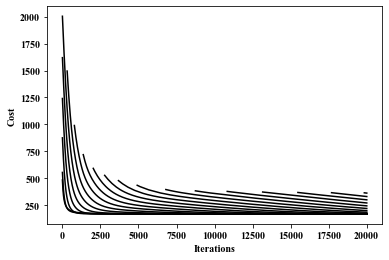

In [69]:
alpha = 0.03  # Learning rate
numOfIterations = 20000  # Number of iterations
numOfRecords,numOfFeatures = X_train.shape
Accuracy = [];  Cost = []
plt.figure()
for i in range(20):
    weights = i*np.ones(numOfFeatures);   bias = i   # Initializing weights and bias
    regressor = logisticRegression(learningRate=alpha,numIters=numOfIterations)
    cost = regressor.fit(X_train,y_train,weights,bias)
    predictions = regressor.predictor(X_test)
    acc = 100*accuracy(y_test,predictions)
    Accuracy.append(acc)
    cst = cost[-1]
    Cost.append(cst)
    plt.plot(range(1,len(cost)+1),cost,c='k')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')

#os.chdir(imageDirectory)
#plt.gcf().subplots_adjust(left=0.16); plt.gcf().subplots_adjust(bottom=0.1)
#plt.savefig('cost_.jpg',dpi=150)
#os.chdir(parentDirectory)
plt.show()

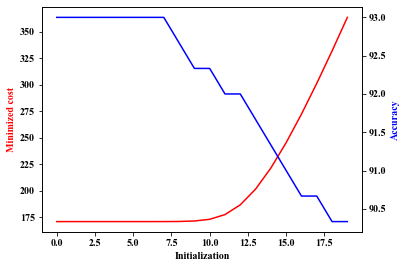

In [72]:
# Comparing cost and accuracy for different initializations
fig,ax = plt.subplots()
ax.plot(range(0,len(Cost)),Cost,color="red")
ax.set_xlabel("Initialization")
ax.set_ylabel("Minimized cost",color="red")
ax2=ax.twinx()
ax2.plot(range(0,len(Accuracy)),Accuracy,color="blue")
ax2.set_ylabel("Accuracy",color="blue")

#os.chdir(imageDirectory)
#plt.gcf().subplots_adjust(left=0.16); plt.gcf().subplots_adjust(bottom=0.1)
#plt.savefig('multi_init.jpg',dpi=150)
#os.chdir(parentDirectory)
plt.show()

##### Evaluating the performance of the model (Confusion Matrix and F1 Score)

In [13]:
confusionMat = pd.crosstab(y_test,predictions,rownames=['Actual'],colnames=['Predicted'],margins=True)
print('Confusion Matrix:\n')
print(confusionMat)
TP = confusionMat[1][1]  # True Positive
TN = confusionMat[0][0]  # True Negative
FP = confusionMat[1][0]  # False Positive
FN = confusionMat[0][1]  # False Negative
print('\nTrue Positive = '+str(TP))
print('True Negative = '+str(TN))
print('False Positive = '+str(FP))
print('False Negative = '+str(FN))
Accuracy = (TP+TN)/confusionMat['All']['All']
precision = (TP)/(TP+FP)
recall = (TP)/(TP+FN)
F1 = 2*(precision*recall)/(precision+recall)
print('\nAccuracy = {:0.3f}'.format(Accuracy))
print('Precision = {:0.3f}'.format(precision))
print('Recall = {:0.3f}'.format(recall))
print('F1 score = {:0.3f}'.format(F1))

Confusion Matrix:

Predicted    0    1  All
Actual                  
0          122    9  131
1            5  164  169
All        127  173  300

True Positive = 164
True Negative = 122
False Positive = 9
False Negative = 5

Accuracy = 0.953
Precision = 0.948
Recall = 0.970
F1 score = 0.959
